In [1]:
import numpy as np
import random
import scipy.stats as stats

# Simulation variables
T = 20. # number of whole time steps in simulation.
dt = 1./252 # 252 trading days in a year

N = 100 # number of trader agents

# Two types of agent:
#
# Fundamentalist traders
# Behavior: buy (or sell) a fixed amount of stocks Tf when 
#  the price is below (or above) a certain, set fundamental value price pf.

pct_Nf = 0.4 # % fundamentalist traders (vs. noise traders)
Nf = int(pct_Nf * N)
# Noise traders
# Behavior: buying and selling behavior is driven by herd instincts.
#  Depending on expectation of future price movement a noise trader will
#  be either an optimist or pessamist.
Nc = N - Nf # noise traders

# Maybe parameter to optimize.
# Noise to Fundamentalist ratio.
ntof = Nc / (Nf + Nc)

b = 0.1 # the speed of price adjustment.

Tf = 1 # fixed transaction volume of a single fundamentalist trader (sensitivity to deviations between fundamental price and market price).
Tc = 1 # fixed transaction volume of a single noise trader.

# Parameter for the rate of contagion.
# Change this and the pattern of traders switching between 
# optimist and pessimist will change. In turn, so will the price fluctuations.
# Constraint: 0.5 * nu * Dt * N <= 1.
nu = 0.8/dt

# Mean return of the underlying security
mu = 0.08   # mean return

class LuxABMSim:
    """A Python class for the Lux ABM trader model.
    
    """
    def __init__(self, N, T, dt):
        self.N = N # total number of traders (fundementalist and noise)
        self.T = T # total elapsed time of simulation
        self.dt = dt # change in time step per increment.
        self.x = None # system state variable: No - Np // Nc
        self.Nc = 0 # number of noise traders
        self.Nf = 0 # number of fundamentalist traders
        self.No = 0 # number of optimist noise traders
        self.Np = 0 # number of pessimist noise traders  

    def initialize(self, pct_Nf, Tf, Tc, p, pf, mu, b, nu):
        """Initialize the Lux ABM for market simulation.
        Args:
            pct_Nf (float): % of total traders that are fundamentalists
            Tf (float): fixed transaction volume of fundamentalist agent.
            Tc (float): fixed transaction volume of noise traders
            p (float): initial price of the market security
            pf (float): fundamental price of the market security
            mu (float): mean return of the security per increment of t
            b (float): the speed of price adjustment
            nu (float): rate of change of optimist/pessimist sentiment contagion
        """
        self.pct_Nf = pct_Nf
        self.Nf = int(self.pct_Nf * self.N) # initialize num. fundamentalists
        self.Nc = self.N - self.Nf # initialize number of noise traders.
        self.Tf = Tf
        self.Tc = Tc
        self.p = p
        self.pf = pf
        self.mu = mu
        self.b = b
        self.nu = nu
        self.t = 0 # initial time step

        # Vector objects to store simulated data
        self.vec_price = [self.p]
        self.vec_price_fund = [self.pf]
        self.vec_No = [self.No]
        self.vec_Np = [self.Np]
        self.vec_x = [self.x]
        self.vec_t = [self.t]

        # Create Nc noise trader agents
        self.traders = np.zeros([1, self.Nc])

        # Initialize the noise traders as optimists or pessimists.
        for i in range(self.Nc):
            # Each noise trader randomly assigned as an
            # "optimist" (1) or "pessimist" (0)
            self.traders[0,i] = random.randint(0, 1)

        self.No = len(self.traders[0, self.traders[0,:] == 1]) # num optimists
        self.Np = len(self.traders[0, self.traders[0,:] == 0]) # num pessimists

        # Calculate system state variable
        # takes values between [-1, 1]
        self.x = (self.No - self.Np) / self.Nc

    def update(self):
        # assign noise traders as either optimist of pessimist
        self.assign_noise_traders()
        
        # update change in security price
        self.calculate_price()

        # update fundamental price
        self.calculate_fundamental_price()

        # update state variable
        self.calculate_system_state()

        # update time step
        self.t += self.dt
        # print("No", self.No)
        # print("Np", self.Np)
        # print("Np + No", self.Np + self.No)
        # print("p", self.p)
        # print("pf", self.pf)
        # print("x", self.x)
        

    def observe(self):
        self.vec_price.append(self.p)
        self.vec_price_fund.append(self.pf)
        self.vec_No.append(self.No)
        self.vec_Np.append(self.Np)
        self.vec_x.append(self.x)
        self.vec_t.append(self.t)
            
    def calculate_o_to_p_prob(self):
        prob_o_to_p = self.nu * self.dt * self.Np / self.Nc
        return prob_o_to_p
    
    def calculate_p_to_o_prob(self):
        prob_p_to_o = self.nu * self.dt * self.No / self.Nc
        return prob_p_to_o

    def assign_noise_traders(self):
        p_op = self.calculate_o_to_p_prob()
        p_po = self.calculate_p_to_o_prob()

        optim = np.random.binomial(1, 1-p_op, self.Nc)
        pessim = np.random.binomial(1, p_po, Nc)

        for i in range(self.Nc):
            # assign probabilities of optimist noise trader agents 
            # switching to pessimist
            if self.traders[0,i] == 1:
                self.traders[0, i] = optim[i]
            else:
                self.traders[0, i] = pessim[i]

        # Count new optimist and pessimist traders
        nNo = self.count_optimist_traders()
        nNp = self.count_pessimist_traders()
        
        # Reflexive boundary conditions
        # Ensure there's at least one optimist and one pessimist noise trader in the market.
        if nNp < 1:
            nNp = 1
            nNo -= 1
        
        if nNo < 1:
            nNo = 1
            nNp -= 1

        self.No = nNo
        self.Np = nNp

        
    def count_optimist_traders(self):
        No = len(self.traders[0, self.traders[0, :] == 1])
        return No
    
    def count_pessimist_traders(self):
        Np = len(self.traders[0, self.traders[0, :] == 0])
        return Np

    def calculate_price(self):
        dp_dt = self.p * self.b * (self.Nf * self.Tf * (self.pf - self.p) + self.Nc * self.Tc * self.x) * self.dt
        self.p += dp_dt

    def calculate_fundamental_price(self):
        npf = self.pf + self.mu * self.pf * self.dt
        self.pf = npf
    
    def calculate_system_state(self):
        nx = (self.No - self.Np) / self.Nc
        self.x = nx

def param_constraint(nu, dt, N):
        # Returns true if parameters violate model constraint.    
        return 0.5 * nu * dt * N > 1
    
def calculate_log_returns(data):
    """Calculates log returns.
    Args:
        data (list): list of price data.
    """
    log_returns = np.diff(np.log(data))
    
    return log_returns

def set_params(pct_Nf, Tf, Tc, p, pf, mu, b, nu):
    params = dict()
    params["pcf_Nf"] = pct_Nf
    params["Tf"] = Tf
    params["Tc"] = Tc
    params["p"] = p
    params["pf"] = pf
    params["mu"] = mu
    params["b"] = b
    params["nu"] = nu
    return params

if __name__ == "__main__":
    sim = LuxABMSim(N = 100, T = 20, dt = 1./252)

    # Parameters to tune
    # pcf_Nf: % of fundamentalist vs. noise traders in the market.
    # Tf: how many shares of a security a fundamentalist trader agent transacts.
    # Tc: how many shares of a security a noise trader agent transacts.
    # b: price adjustment parameter
    # nu: contagion of noise traders switching from optimist to pessimist

    # Create a looping functions around
    # this to change parameters
    
    # list to store tuple of (params, results)
    trials = []
    
    params = set_params(
        pct_Nf = 0.4,
        Tf = 1, 
        Tc = 28,
        p = 10.0,
        pf = 10.0,
        mu = 0.08,
        b = 0.2505,
        nu = 0.0007/ dt
    )
    
    # 'param': {'tf': 1.0, 'tc': 28.0, 'nu': 0.0007000000000000001, 'b': 0.2505}}

    if param_constraint(params["nu"], sim.dt, sim.N):
        print("parameters violate constraint")
    

    sim.initialize(
        pct_Nf=params["pcf_Nf"],
        Tf=params["Tf"],
        Tc=params["Tc"],
        p=params["p"],
        pf=params["pf"],
        mu = params["mu"],
        b = params["b"],
        nu = params["nu"]
    )

    while sim.t < sim.T:
        sim.update()
        sim.observe()

    print(calculate_log_returns(sim.vec_price))
    print("hi")

[ 0.00000000e+00  1.26220303e-04  2.02285385e-04 ...  3.60608633e-01
 -3.61327531e-01  3.62329845e-01]
hi


In [2]:
data = calculate_log_returns(sim.vec_price)
len(data)

5040

In [3]:
data[:10]

array([0.        , 0.00012622, 0.00020229, 0.00024813, 0.00027577,
       0.00029242, 0.00030246, 0.00030851, 0.00031215, 0.00031434])

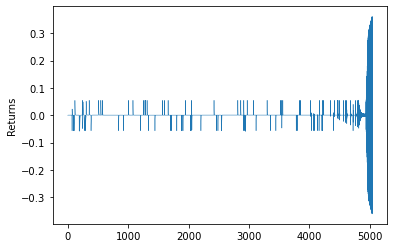

In [4]:
import matplotlib.pyplot as plt
plt.plot(data, linewidth=0.5)
plt.ylabel('Returns')
plt.show()

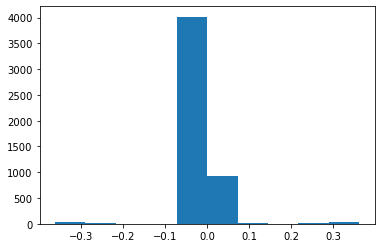

In [5]:
plt.hist(data, bins=10)
plt.show()

In [6]:
mu = np.mean(data)
sigma = np.std(data)
sigma2 = np.var(data)
skew = stats.skew(data)
kurt = stats.kurtosis(data)

print('Simulation Stats (daily log returns):')
print('Mean:\t\t\t', mu)
print('Std dev:\t\t', sigma)
print('Variance:\t\t', sigma2)
print('Skew:\t\t\t', skew)
print('Excess kurt:\t\t', kurt)

Simulation Stats (daily log returns):
Mean:			 0.00036000165367610433
Std dev:		 0.04220827223632724
Variance:		 0.0017815382451759128
Skew:			 0.029814676581545782
Excess kurt:		 52.80190300851762
